In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 

=================================================================================================================
# Lecture Notes: Data Preprocessing


##### D.Vidotto, Data Mining: JBI030 2019/2020


=================================================================================================================

**Data Preprocessing** is probably the most important (and *time-consuming*) step in Data Mining. Here, we are assuming that our data have already been collected or extracted from some database. 

99.99% of the times, raw data are not ready for Machine Learning algorithms. Instead, they are likely to be *messy*: we can find missing or innacurate data, nominal values that need to be converted into nominal ones, noisy features, outliers, and so on. Therefore, properly pre-processing the data is extremely important. This should by no means be an automated and mechanical process; instead, it requires careful understanding and knowledge of the dataset. In fact, the steps undertaken during this stage strongly affect all the subsequent steps of data analysis (model results, model selection, model evaluation,...). 

With this lecture, we are going to explore some of the most common pre-processing techniques. The methods discussed here are not an exhaustive list of methods though; students are invited to visit the `scikit-learn` [documentation](https://scikit-learn.org/stable/modules/preprocessing.html) for other insights. 

In this notebook we are going to cover: 

1. data import
1. train/test set splitting
1. data description and visualization
1. feature engineering
1. data cleaning:
  * missing data
  * discretization/encoding
  * scaling
  * pipelines
1. outlier detection
1. dimensionality reduction:
  * uninformative variables 
  * feature selection 
  * PCA 
1. imbalanced data

## 1. Data Import 

For dataset exploration, manipulation, and import, we use the `pandas` library. In order to import a csv file, we can use the following code: 

In [2]:
heart_data = pd.read_csv("data/heart_data/heart.csv")

Data can be imported in other ways and from many sources:

 * use the `pandas` [readers](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html) to import different formats, such as HTML, JSON, SQL, and others

 * Download a dataset (for instance, the *mnist* dataset) from the [OpenML](https://www.openml.org/) website with `scikit-learn`: 
 
 ```python
 from sklearn.datasets import fetch_openml
 X, y = fetch_openml('mnist_784', version=1, 
                       return_X_y=True)
 ```

* Load [one of the datasets](https://scikit-learn.org/stable/datasets/index.html) already present in the `scikit-learn` library 



In what follows, we will continue working with the *heart* data.

======================================================================

During this course, we will mainly work with *rectangular* (or *structured*) datasets: they contain the **examples** or (units) in their rows, and **features** (or attributes) measured on the examples in their columns. 

An example of such structure can be seen in the dataset we have just imported:

In [3]:
heart_data.head()
# Note: .head() shows only the first rows of the dataset

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In particular, the data frame is composed of 303 examples and 15 variables: 

In [4]:
heart_data.shape

(303, 15)

Some features, such as `MaxHR`, `OldPeak`, `Ca`, are numerical (continuous and discrete); others, such as `ChestPain` and `AHD`, are nominal; others, instead, seem to be *dummy* (0-1) variables, which denote the presence/absence of some characteristic (e.g., the variable `ExAng`). <br> 
More information about the attributes in this dataset can be found [here](https://www.mldata.io/dataset-details/heart_disease/). As we can see, the last variable (`AHD`, which stands for *atheroscleratic heart disease*) is the variable that measures the presence/absence of the heart disease. This is the variable we want to predict given all the other medical and personal measures of 303 patients: the type of analysis we want to perform is a *supervised learning* task. Because the output variable is binary (there are two classes: presence/absence of the disease), we will perform *classification*. 

It is always a good practice to separate the input features (predictors) from the output; furthermore, it is possible to transform the output from text (labels) form to numeric form*:

*= Although, when working with `scikit-learn` models, this is not necessary; they transform the output automatically, and classes can be recovered with the algorithms' `classes_` attribute. An alternative is to use the [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) transformer in `scikit-learn`.    

In [5]:
X = heart_data.drop('AHD', axis=1)
y = heart_data['AHD']
y_num = pd.factorize(y)[0]

In [6]:
X.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal


Remember to observe how each class is mapped to numbers by the `factorize` function:

In [7]:
pd.DataFrame({'y':y, 'y_num':y_num}).head()

,y,y_num
0,No,0
1,Yes,1
2,Yes,1
3,No,0
4,No,0


Last, we are going to modify the name of the first variable (`Unnamed: 0`), since it is a bit cumbersome. This feature looks like a subject identifier, and we will modify it as such: 

In [8]:
X.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
heart_data.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
X.head()

,ID,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal


## 2. Train/Test Set Split

If we do not have already a separate sample to test the performance of Data Mining algorithms, the first operation that should be performed is to create a separate *test set* for this purpose (at least if the dataset is large enough). It is important to create a test set even before performing any sort of data exploration, since *getting to know* the test data during the exploratory step can already bias our judgements on the potential next steps to undertake. Instead, for data exploration and model training, we will use the other portion of data, called *training set*. 

In `scikit-learn`, you can easily separate the training and test set with the `train_test_split()` function, which performs a random split of the data. The function allows you to select the desired proportion of units for the test set. Depending on the dataset size, typical proportions of the training set vary between 60% and 90%. In this example, we are going to allocate 80% to the training set (note also the use of the `random_state` parameter, to endure reproducibility): 

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_num, test_size=0.2, random_state=2)

In [10]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((242, 14), (61, 14), (242,), (61,))

While normal train/test split is recommended in regression, it might be not the best strategy to pursue in classification. Due to randomness, at times there is the chance to obtain non-representative proportions of the class in the train/test sets. With the above split we obtain the following distributions of the output:   

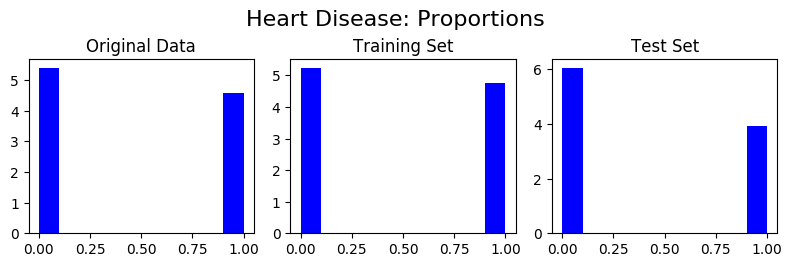

In [11]:
y_orig_series = pd.Series(y_num)
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)   
fig, axes = plt.subplots(1, 3, figsize=(8,2.5), dpi=100)
axes[0].hist(y_orig_series, color='blue', density=True)
axes[0].set_title('Original Data')
axes[1].hist(y_train_series, color='blue', density=True)
axes[1].set_title('Training Set')
axes[2].hist(y_test_series, color='blue', density=True)
axes[2].set_title('Test Set')
plt.suptitle('Heart Disease: Proportions', y=1.05, size=16)
plt.tight_layout();

In [12]:
pd.DataFrame({"y_original":y_orig_series.value_counts(normalize=True),
"y_train":y_train_series.value_counts(normalize=True),
"y_test":y_test_series.value_counts(normalize=True)})

,y_original,y_train,y_test
0,0.541254,0.524793,0.606557
1,0.458746,0.475207,0.393443


As we can see, the proportion of patients with heart disease ($y=1$) is over-represented in the training set and under-represented in the test set. While the differences are not so big here, there can be cases (for instance, with *imbalanced data*; see Section 8 below) where the differences between labels proportions can be exacerbated. <br>
A way to overcome this issue is with *stratified* sampling, which performs the split based on the proportion of the labels:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_num, test_size=0.2, stratify=y_num, random_state=2)

In [14]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((242, 14), (61, 14), (242,), (61,))

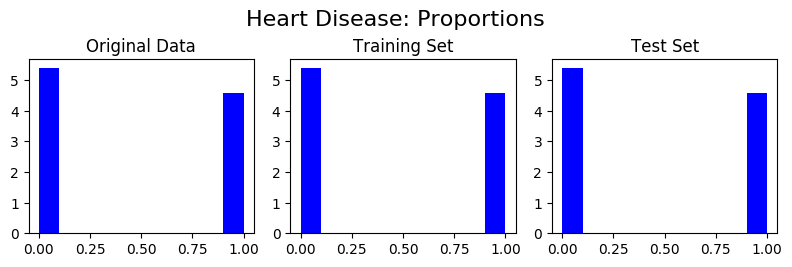

In [15]:
y_orig_series = pd.Series(y_num)
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)
%matplotlib inline    
fig, axes = plt.subplots(1, 3, figsize=(8,2.5), dpi=100)
axes[0].hist(y_orig_series, color='blue', density=True)
axes[0].set_title('Original Data')
axes[1].hist(y_train_series, color='blue', density=True)
axes[1].set_title('Training Set')
axes[2].hist(y_test_series, color='blue', density=True)
axes[2].set_title('Test Set')
plt.suptitle('Heart Disease: Proportions', y=1.05, size=16)
plt.tight_layout();

In [16]:
pd.DataFrame({"y_original":y_orig_series.value_counts(normalize=True),
"y_train":y_train_series.value_counts(normalize=True),
"y_test":y_test_series.value_counts(normalize=True)})

,y_original,y_train,y_test
0,0.541254,0.541322,0.540984
1,0.458746,0.458678,0.459016


Now the class labels are fairly represented both in the training and in the test set. <br>
**Note**: when the dataset is too large for the main memory of your local machine (and models cannot be estimated for this reason), a possible solution is to use a *subsample* of the data. `train_test_split` can be used in this case (or the `sample` function of Pandas). 

## 3. Data Description and Visualization

The main summary statistics of the data can be queried with the `describe` command in `pandas`: 

In [17]:
# This will only return summary statistics for the numeric columns
X_train.describe()

,ID,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,238.000000
mean,153.632231,54.661157,0.661157,131.334711,248.045455,0.169421,0.962810,149.376033,0.318182,1.067355,1.603306,0.726891
std,87.806187,9.157953,0.474297,18.029009,54.001940,0.375901,0.995144,22.862459,0.466736,1.181026,0.617576,0.979210
min,1.000000,34.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,78.250000,48.000000,0.000000,120.000000,211.250000,0.000000,0.000000,134.500000,0.000000,0.000000,1.000000,0.000000
50%,154.000000,56.000000,1.000000,130.000000,242.500000,0.000000,0.000000,152.500000,0.000000,0.800000,2.000000,0.000000
75%,230.500000,61.000000,1.000000,140.000000,282.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,303.000000,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,195.000000,1.000000,6.200000,3.000000,3.000000


In [18]:
# Summaries of the nominal columns can be obtained as follows:
X_train.describe(include=['object'])

,ChestPain,Thal
count,242,241
unique,4,3
top,asymptomatic,normal
freq,113,134


`pandas`, by means of the `plotting` module, allows for the visualization of a scatter matrix. The plot shows bivariate relationships in the off diagonals, and the univariate distributions (histograms) in the diagonal. 

In [19]:
# We create a temporary dataset, where the features and the output labels are merged together
all_train = X_train
all_train = all_train.assign(y=y_train)

To avoid problems with data visualization, we will only retain the observations without missing data in the dataset. This can be obtained by filtering the DataFrame rows via the boolean `notna()` in combination with `all`: 

In [20]:
all_train_no_na = all_train[all_train.notna().all(axis=1)]

Let's now visualize the scatter matrix; data points in the off-diagonal will be colored by class: 

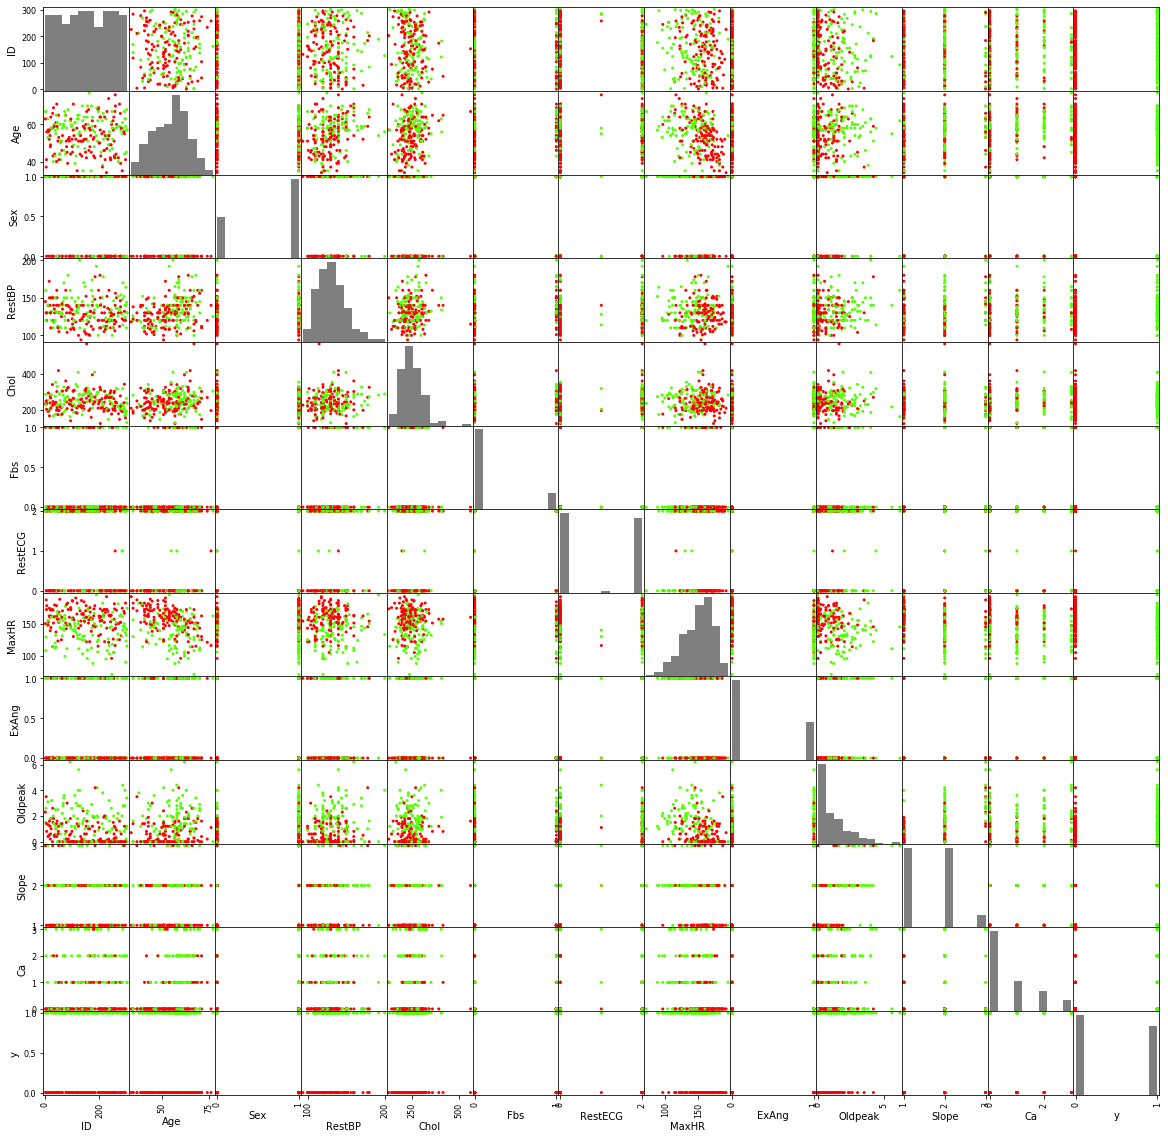

In [21]:
from pandas.plotting import scatter_matrix
scatter_matrix(all_train_no_na, c =all_train_no_na['y'], figsize=(20,20), 
              cmap="prism", hist_kwds={'color':'black', 'alpha':0.5}, alpha=1.)
plt.show()

We can 'zoom in' to only some of the features:

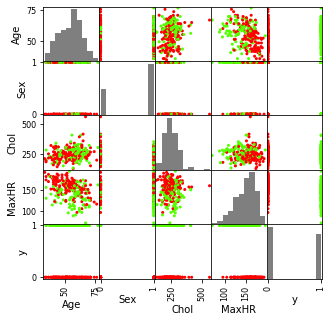

In [22]:
selected_vars = ['Age', 'Sex', 'Chol', 'MaxHR', 'y']
scatter_matrix(all_train_no_na[selected_vars], c =all_train_no_na['y'], figsize=(5,5), 
              cmap="prism", hist_kwds={'color':'black', 'alpha':0.5}, alpha=1.)
plt.show()

To visualize only one bivariate relationship:

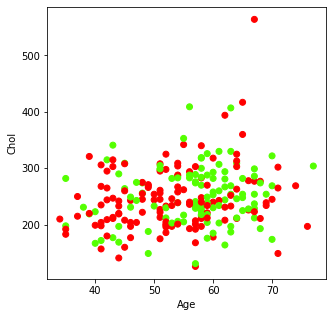

In [23]:
plt.figure(figsize=(5,5))
plt.scatter(all_train_no_na['Age'], all_train_no_na['Chol'], 
            c=all_train_no_na['y'], cmap="prism")
plt.xlabel("Age")
plt.ylabel("Chol")
plt.show()

We can also explore the correlations in the data:

In [24]:
# Only the features
X_train.corr()

,ID,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
ID,1.000000,-0.014666,-0.113000,-0.061704,-0.096158,-0.051533,-0.193523,-0.113697,-0.040973,-0.158791,0.002961,0.053870
Age,-0.014666,1.000000,-0.091502,0.281405,0.209133,0.142101,0.167073,-0.375853,0.061246,0.192367,0.194765,0.357798
Sex,-0.113000,-0.091502,1.000000,-0.077908,-0.201576,0.044046,-0.009227,-0.040625,0.132912,0.139433,0.063336,0.105006
RestBP,-0.061704,0.281405,-0.077908,1.000000,0.121290,0.226706,0.106620,0.002794,0.055340,0.204236,0.154706,0.109985
Chol,-0.096158,0.209133,-0.201576,0.121290,1.000000,0.007591,0.212598,0.010284,0.057702,0.034850,-0.023470,0.126802
Fbs,-0.051533,0.142101,0.044046,0.226706,0.007591,1.000000,0.094560,-0.022894,-0.001075,0.001294,0.022601,0.148623
RestECG,-0.193523,0.167073,-0.009227,0.106620,0.212598,0.094560,1.000000,-0.064674,0.061317,0.084754,0.131182,0.156233
MaxHR,-0.113697,-0.375853,-0.040625,0.002794,0.010284,-0.022894,-0.064674,1.000000,-0.346842,-0.318786,-0.416105,-0.239113
ExAng,-0.040973,0.061246,0.132912,0.055340,0.057702,-0.001075,0.061317,-0.346842,1.000000,0.275610,0.281363,0.080760
Oldpeak,-0.158791,0.192367,0.139433,0.204236,0.034850,0.001294,0.084754,-0.318786,0.275610,1.000000,0.589184,0.280904


We can view the Pearson correlations between the output and the features (notice that in case of binary output this is a [point-biserial correlation](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient)): 

In [25]:
all_train.corr()["y"]

ID         0.051941
Age        0.188389
Sex        0.291046
RestBP     0.147886
Chol       0.069241
Fbs        0.004293
RestECG    0.193133
MaxHR     -0.371744
ExAng      0.386035
Oldpeak    0.418120
Slope      0.350297
Ca         0.448840
y          1.000000
Name: y, dtype: float64

We can also see an heatmap of the correlations:

In [26]:
all_train.corr().style.background_gradient(cmap='Blues')

,ID,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,y
ID,1,-0.0146659,-0.113,-0.0617042,-0.0961583,-0.0515329,-0.193523,-0.113697,-0.0409732,-0.158791,0.00296083,0.05387,0.0519408
Age,-0.0146659,1,-0.0915023,0.281405,0.209133,0.142101,0.167073,-0.375853,0.0612463,0.192367,0.194765,0.357798,0.188389
Sex,-0.113,-0.0915023,1,-0.0779078,-0.201576,0.0440462,-0.00922708,-0.0406249,0.132912,0.139433,0.0633365,0.105006,0.291046
RestBP,-0.0617042,0.281405,-0.0779078,1,0.12129,0.226706,0.10662,0.00279393,0.0553399,0.204236,0.154706,0.109985,0.147886
Chol,-0.0961583,0.209133,-0.201576,0.12129,1,0.007591,0.212598,0.0102838,0.0577019,0.03485,-0.0234698,0.126802,0.0692407
Fbs,-0.0515329,0.142101,0.0440462,0.226706,0.007591,1,0.0945599,-0.0228941,-0.00107502,0.00129384,0.0226009,0.148623,0.00429349
RestECG,-0.193523,0.167073,-0.00922708,0.10662,0.212598,0.0945599,1,-0.0646743,0.0613169,0.0847541,0.131182,0.156233,0.193133
MaxHR,-0.113697,-0.375853,-0.0406249,0.00279393,0.0102838,-0.0228941,-0.0646743,1,-0.346842,-0.318786,-0.416105,-0.239113,-0.371744
ExAng,-0.0409732,0.0612463,0.132912,0.0553399,0.0577019,-0.00107502,0.0613169,-0.346842,1,0.27561,0.281363,0.0807598,0.386035
Oldpeak,-0.158791,0.192367,0.139433,0.204236,0.03485,0.00129384,0.0847541,-0.318786,0.27561,1,0.589184,0.280904,0.41812


(Note: these values correspond to estimates of the Pearson coefficients. Such values must be properly tested for statistical meaning).

## 4. Feature Engineering

*Feature Engineering* seeks to create new features out of the existing ones, by transforming them. They usually require a great knowledge of the data and of the problem at hand, which is also known as *domain knowledge*. It is always advisable to create such variables with domain experts. 
<br> 
In the heart data example, we might try to create a variable that measures the interaction of cholesterol by sex:

In [27]:
all_train["CholBySex"] = all_train["Chol"] * all_train["Sex"]

We can add this new feature to our training and test data: 

In [28]:
X_train = X_train.assign(CholBySex = all_train["CholBySex"])
X_test = X_test.assign(CholBySex = X_test["Chol"] * X_test["Sex"])

**Note**: it is also possible to perform other types of transformations on the features, such as arithmetic ones (log(x), 1/x, $\sqrt{x}$, polynomial transformations such as $x^2, x^3,...$, and so on). Some of these transformations (especiallyy logarithms and square roots) can be useful to transform skewed and asymmetrical distributions into (approximatively) symmetric ones. Some algorithms can actually benefit from such transformations. 

## 5. Data Cleaning

To apply the following data preprocessing techniques, we will need to separate the nominal features from the numeric ones; this is because nominal and numeric features have their own manipulation methods. 

In [29]:
# Note: 'object' dtypes denote character (nominal) variables in pandas
X_train.dtypes

ID             int64
Age            int64
Sex            int64
ChestPain     object
RestBP         int64
Chol           int64
Fbs            int64
RestECG        int64
MaxHR          int64
ExAng          int64
Oldpeak      float64
Slope          int64
Ca           float64
Thal          object
CholBySex      int64
dtype: object

In [30]:
X_train_cat = X_train.select_dtypes(include=['object'])
X_test_cat = X_test.select_dtypes(include=['object'])
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_test_num = X_test.select_dtypes(include=['int64', 'float64'])

In [31]:
list(X_train_cat.columns)

['ChestPain', 'Thal']

In [32]:
list(X_train_num.columns)

['ID',
 'Age',
 'Sex',
 'RestBP',
 'Chol',
 'Fbs',
 'RestECG',
 'MaxHR',
 'ExAng',
 'Oldpeak',
 'Slope',
 'Ca',
 'CholBySex']

However, there are some features among the numeric ones that are 'dummy' (binary) variables, taking only values 0 and 1: 

In [33]:
print("Number of observed values per feature:")
{x:len(X_train_num[x].value_counts()) for x in X_train_num.columns}

Number of observed values per feature:


{'ID': 242,
 'Age': 40,
 'Sex': 2,
 'RestBP': 47,
 'Chol': 139,
 'Fbs': 2,
 'RestECG': 3,
 'MaxHR': 85,
 'ExAng': 2,
 'Oldpeak': 39,
 'Slope': 3,
 'Ca': 4,
 'CholBySex': 105}

Thus, continuous features will be separated from the binary ones:  

In [34]:
# Create indicator variable for binary features 
is_binary = [len(X_train_num[x].value_counts())==2 for x in X_train_num.columns]

In [35]:
# Separate binary variables from others 
X_train_cont = X_train_num.iloc[:, is_binary==np.repeat(False, len(is_binary))]
X_test_cont = X_test_num.iloc[:, is_binary==np.repeat(False, len(is_binary))]
X_train_bin = X_train_num.iloc[:, is_binary==np.repeat(True, len(is_binary))]
X_test_bin = X_test_num.iloc[:, is_binary==np.repeat(True, len(is_binary))]
X_train_cont.head()

,ID,Age,RestBP,Chol,RestECG,MaxHR,Oldpeak,Slope,Ca,CholBySex
278,279,57,154,232,2,164,0.0,1,1.0,232
71,72,67,125,254,0,163,0.2,2,2.0,254
235,236,54,122,286,2,116,3.2,2,2.0,286
217,218,46,138,243,2,152,0.0,2,0.0,0
302,303,38,138,175,0,173,0.0,1,NaN,175


In [36]:
X_train_bin.head()

,Sex,Fbs,ExAng
278,1,0,0
71,1,1,0
235,1,0,1
217,0,0,1
302,1,0,0


============================================================================================
#### Digression: scikit-learn design
All `scikit-learn` learn objects share a user-friendly interface. As we have seen in the `scikit-learn` tutorial, such objects can be categorized in:
 
 * **estimators**, which -by means of the `fit()` method- take that data as inputs (along with other *hyperparameters*) and estimate some parameters   
 * **transformers**, a type of estimator that can transform the data by means of the `transform()` method; they can also be called with the `fit_transform()` method, which is equivalent to calling the `fit()` function, followed by `transform()`
 * **predictors**, which are estimators that can perform predictions (usually after training a model by means of the `fit()` function) via the `predict()` method
 
============================================================================================
 

### 5.1 Missing Data

Missing Data are unobserved, empty cells (usually denoted by `nan` in `pandas`). They represent unavailable information, and must be properly handled: not doing so can lead to inaccurate results in subsequent steps. Furthermore, many `scikit-learn` algorithms don't work if some of the entries of the dataset are empty. 
<br>
To count the amount of missing data in the feature matrix, simply type:

In [37]:
X_train.isnull().sum()

ID           0
Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           4
Thal         1
CholBySex    0
dtype: int64

In this notebook, we are going to explore two ways to deal with missing data: 
 * removing incomplete observations 
 * univariate imputation 
<br>

There are other methods, such as *multiple imputation* or *multivariate imputation*, that are not covered here; students that are interested can find more information about missing data treatment [in this page](https://scikit-learn.org/stable/modules/impute.html).
Which method to use depends on the nature of the data, on the mechanism that has generated the missing data, and on the assumptions we make on such mechanism. For this reason, it is always important to understand and get to know the way the data had been collected.   

#### 5.1.1 Dropping Missing Observations
As we have seen in the Pandas tutorial, removing examples with incomplete data is as simple as typing:

In [38]:
X_train_nomissing = X_train.dropna()

In [39]:
X_train_nomissing.shape

(237, 15)

This method should be used cautiously: when the fraction of empty entries is large and/or the missingness mechanism is not **completely at random**, it could strongly affect (and bias) the final results. 

#### 5.1.2 Univariate Imputation 
**Imputations** are values used to replace the missing entries of the dataset. In this way, we retain the original sample size of the dataset, and we seek to reduce the amount of information lost with the missing data. <br>
There are several strategies that can be used to impute the missing data; in what follows, we use the variables *medians* (for numeric data) and *modes* (for nominal data) for the imputations. 

In [40]:
from sklearn.impute import SimpleImputer
# Initialize the imputers
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
# Fit the parameters (in this case, means and modes) and transform the data (in this case, perform the imputations)
X_train_cont_imp = pd.DataFrame(num_imputer.fit_transform(X_train_cont))
X_train_cat_imp = pd.DataFrame(cat_imputer.fit_transform(X_train_cat))
# Impute the test data WITH THE PARAMETERS ESTIMATED USING THE TRAINING DATA!
X_test_cont_imp = pd.DataFrame(num_imputer.transform(X_test_cont))
X_test_cat_imp = pd.DataFrame(cat_imputer.transform(X_test_cat))

In [41]:
# The original sample size is preserved:
(X_train_cont_imp.shape, X_train_cat_imp.shape)

((242, 10), (242, 2))

We can visualize the used hyperparameters and estimated parameters (for the latter, we should remember to add an underscore `_` at the end):

In [42]:
num_imputer.strategy

'median'

In [43]:
# Medians of the features
num_imputer.statistics_

array([154. ,  56. , 130. , 242.5,   0. , 152.5,   0.8,   2. ,   0. ,
       209.5])

(Another common strategy used for the imputation of numeric data is by using the variable means; this, however, is more sensitive to outliers. )
<br>
*    *    *
This imputation method is also called *univariate*, because it is based on univariate statistics of the features. While cheap and easy to understand, this method disregards possible relationships among the features (and the output). Multivariate imputation methods are available in `scikit-learn`; check, for instance, the `KNNImputer()` function in the documentation.  

#### 5.1.3 Comparing the results

In [44]:
pd.DataFrame({"original data":(X_train.iloc[:,12].mean(),
                                           X_train.iloc[:,12].median(),
                                          X_train.iloc[:,12].std()), 
             "dropping missing cases":(X_train_nomissing.iloc[:,12].mean(),
                                           X_train_nomissing.iloc[:,12].median(),
                                          X_train_nomissing.iloc[:,12].std()), 
             "imputed data":(X_train_cont_imp.iloc[:,8].mean(),
                             X_train_cont_imp.iloc[:,8].median(),
                             X_train_cont_imp.iloc[:,8].std())},
              index=["mean", "median", "std.deviation"] )

,original data,dropping missing cases,imputed data
mean,0.726891,0.729958,0.714876
median,0.000000,0.000000,0.000000
std.deviation,0.979210,0.980136,0.975480


We will continue the preprocessing steps with the imputed data. 

### 5.2 Encoding nominal features
Several Machine Learning algorithms cannot deal with the labels of categorical data, which are usually in form of text; it is therefore necessary to convert such features into numeric ones. This type of operation is called *encoding*. 

We will consider two types of encoding here: 
 * ordinal encoding
 * one-hot encoding
 
More information about such operations can be found [here](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features). 

### 5.2.1 Ordinal Encoding
Ordinal Encoding assigns an integer to each category of the feature; for example,

$$[young, adult, old, young] \rightarrow [0, 1, 2, 0]$$

While this method can seem attractive at first (for instance, it maintains the original nunmber of features in the dataset), it should be used with caution: the features are now interpreted as numeric variables by the machine learning algorithms. If there is a natural ordering of the categories, such as in the example above, this works fine. However, if there is no natural ordering (as for example with the weather: $[sunny, overcast, rainy]$), then this behaviour is not the optimal one. 
<br>
This code executes ordinal encoding: 

In [45]:
from sklearn.preprocessing import OrdinalEncoder
# Initialization:
ord_enc = OrdinalEncoder()
# Fit/Transform Training data:
X_train_cat_ord_enc = pd.DataFrame(ord_enc.fit_transform(X_train_cat_imp))
# Transform Test Data
X_test_cat_ord_enc = pd.DataFrame(ord_enc.transform(X_test_cat_imp))

In [46]:
X_train_cat_ord_enc.head()

,0,1
0,2.0,1.0
1,0.0,2.0
2,0.0,1.0
3,0.0,1.0
4,1.0,1.0


### 5.2.2 One-Hot Encoding
Unlike Ordinal Encoding, One-Hot encoding (a.k.a. dummy variables encoding in Statistics) creates as many variables as the number of categories in the feature. In particular, each of this new variables is binary (0-1 values; also called indicator variable in statistics), which is equal to 1 whenever the examples take on the reference value. 
<br>
For example, if the feature is describing colors, and the observed vector is the following one: 

$$[yellow, green, red, green]$$

then one-hot encoding will produce the following output: 
<br>

| Yellow | Green | Red |
|:------:|:-----:|:---:|
| 1 | 0 | 0 |
| 0 | 1 | 0 | 
| 0 | 0 | 1 | 
| 0 | 1 | 0 |

This encoding preserves the non-ordinal, nominal information of the features, but it has the downside of creating a huge number of variables when the number of categories/categorical features is large. When this happens, a possible solution is to *collapse* some of the categories together into a unique one. 

We have already seen in the `Pandas` tutorial how to obtain one-hot encoded variables with the `pandas.get_dummies` function. Here, we will see how to perform the same operation with `scikit-learn`. 

In [47]:
from sklearn.preprocessing import OneHotEncoder
oh_enc = OneHotEncoder(sparse=False)
X_train_cat_oh_enc = pd.DataFrame(oh_enc.fit_transform(X_train_cat_imp))
X_test_cat_oh_enc = pd.DataFrame(oh_enc.transform(X_test_cat_imp))

In [48]:
X_train_cat_oh_enc.head()

,0,1,2,3,4,5,6
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [49]:
# 7 categories have been encoded:
oh_enc.categories_

[array(['asymptomatic', 'nonanginal', 'nontypical', 'typical'],
       dtype=object), array(['fixed', 'normal', 'reversable'], dtype=object)]

**Note**. When estimating linear *non-regularized models*, such as standard (unpenalized) linear regression (with intercept) or  non-regularized neural networks, One-Hot encoding will cause collinearity problems, as the resulting variables will be linearly dependent. It is possible to overcome this issue (without loosing information) by dropping one of the encoded variables (for instance, the first one), which will become the *baseline* or reference category. To achieve this, simply add the `drop=first` option when initializing `OneHotEncoder`.
*    *    * 
We are going to continue the data pre-processing phase with the one-hot encoded dataset.

### 5.3 Discretizing numeric features
*Discretization* consists of transforming continuous features into nominal ones, e.g. by detecting reasonable breaking points and creating the *partitions*, or *bins*, in the resulting sub-sets. 
<br>
The `pandas` function `cut` can perform discretization of the columns of a dataset: 

```python
pd.cut(X_train_num_imp.iloc[:,0], 3, labels=['low', 'medium', 'high'])
```

Another option is the function [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer) from `scikit-learn`. 

### 5.4 Scaling
In raw datasets, numeric features are usually observed under different scales: thousands of dollars, hundreds of grams, meters, and so on. Machine learning algorithms are not aware of these differences, and will most likely end up giving more weights to variables with larger variances (i.e., the ones that vary the most). 
<br> 
**Scaling** transforms the attributes so that the new variables vary within a comparable range of values. Importantly, while the features are re-scaled, their correlation structure is left untouched, so that the information about what attributes are the strongest predictors of the output is not lost. <br>
There are two main ways of doing scaling: 
 * standardization
 * normalization
 
The scikit-learn documentation contains a nice [motivating example](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html) of why performing scaling is a relevant preprocessing step.

#### 5.4.1 Standardization
Standardization consists of two main steps: 
 1. shift each feature by subtracting its mean, in such a way that becomes centerd at 0 
 1. rescale by dividing each feature by its standard deviation, in such a way to have unit variance (i.e., variance equal to 1)
 
In this way, the new $j$-th feature $X^*_j$ is calculated as: 

$$ X^*_j = \frac{X_j - \bar{X}_j}{sd(X_j)} $$
 
Standardization in scikit-learn can be performed in this way:

In [50]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X_train_cont_standardized = pd.DataFrame(standardizer.fit_transform(X_train_cont_imp))
X_test_cont_standardized = pd.DataFrame(standardizer.transform(X_test_cont_imp))

In [51]:
X_train_cont_standardized.mean().round(decimals=2)

0    0.0
1   -0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float64

In [52]:
X_train_cont_standardized.std().round(decimals=2)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

We can see the means and scales used for the standardization of the features: 

In [53]:
(standardizer.mean_, standardizer.scale_)

(array([153.6322314 ,  54.66115702, 131.33471074, 248.04545455,
          0.96280992, 149.37603306,   1.06735537,   1.60330579,
          0.71487603, 158.8553719 ]),
 array([ 87.62458117,   9.13901248,  17.99172083,  53.89025043,
          0.9930862 ,  22.81517374,   1.17858317,   0.61629845,
          0.97346286, 119.07751379]))

### 5.4.2 Normalization
While standardization gives all the features the same mean and variance, normalization makes them vary within the same range (usually between 0 and 1). This happens by applying a simple transformation in orden to obtain a new feature $X^*_j$:

$$ X^*_j = \frac{X_j-min(X_j)}{max(X_j)-min(X_j)} $$

where $max()$ and $min()$ correspond to the maximum and minumum observed values of the $j$-th feature. 

In [54]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()
X_train_cont_normalized = pd.DataFrame(normalizer.fit_transform(X_train_cont_imp))
X_test_cont_normalized = pd.DataFrame(normalizer.transform(X_test_cont_imp))

In [55]:
pd.DataFrame({'max':X_train_cont_normalized.max(),
              'min':X_train_cont_normalized.min()})

,max,min
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


In the following sections we will continue the analyses with the standardized dataset. 

## Merging the datasets
At this point, we are going to merge the datasets obtained after preprocessing the nominal and numeric features. 

In [56]:
# Because the datasets were converted internally by scikit-learn into numpy arrays, information about 
# the row names (index) was lost during the processing stage; we must 
# restore it first, in order not to incur into the risk to "shuffle" the 
# values for some features 
X_train_cont_standardized.index = X_train.index
X_train_cat_oh_enc.index = X_train.index 
X_test_cont_standardized.index = X_test.index
X_test_cat_oh_enc.index = X_test.index 
# Let's reindex also the classes: 
y_train= pd.Series(y_train, index = X_train.index)
y_test = pd.Series(y_test, index = X_test.index)

In [57]:
X_train_processed = pd.concat([X_train_cont_standardized,X_train_cat_oh_enc, X_train_bin], axis=1)
X_test_processed = pd.concat([X_test_cont_standardized, X_test_cat_oh_enc, X_test_bin], axis=1 )
# Update variable names 
new_var_names = list(X_train_cont.columns)
new_var_names = new_var_names
for var in range(2):
    new_var_names = new_var_names + list(X_train_cat.columns[var]+'_'+oh_enc.categories_[var])
new_var_names = new_var_names + list(X_train_bin.columns)
X_train_processed.columns = new_var_names
X_test_processed.columns = new_var_names

In [58]:
X_train_processed.head()

,ID,Age,RestBP,Chol,RestECG,MaxHR,Oldpeak,Slope,Ca,CholBySex,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,Sex,Fbs,ExAng
278,1.430737,0.255919,1.259762,-0.297743,1.044411,0.640975,-0.905626,-0.978918,0.292897,0.614261,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0
71,-0.931613,1.350129,-0.352090,0.110494,-0.969513,0.597145,-0.735931,0.643672,1.320157,0.799014,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0
235,0.940008,-0.072344,-0.518834,0.704293,1.044411,-1.462888,1.809499,0.643672,1.320157,1.067747,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,1
217,0.734586,-0.947713,0.370464,-0.093625,1.044411,0.115010,-0.905626,0.643672,-0.734364,-1.334050,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
302,1.704633,-1.823081,0.370464,-1.355448,-0.969513,1.035450,-0.905626,-0.978918,-0.734364,0.135581,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0


### 5.5 Pipelines
Instead of performing one operation at a time, it is possible to combine several data transformation steps with the use of **pipelines**. Pipelines allow performing all the transformation described in this section (plus many others!) within just one single command. In general, we should create separate pipeline sequences for numeric and nominal variables; fortunately, `scikit-learn` provides the `ColumnTransformer` function which help us to combine pipelines. Both `pipeline` and `ColumnTransformer` use the same methods we have encountered for transformers: `fit`, `fit_transform` and `transform`. 

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
num_var_names = list(X_train_cont)
cat_var_names = list(X_train_cat)
# pipeline takes an arbitrary name of each transformation, and the transformer (with parameters) as input
num_pipe = Pipeline([
    ("num_imp", SimpleImputer(strategy='median')), 
    ("scale_standard", StandardScaler())    
])

cat_pipe = Pipeline([
    ("cat_imp", SimpleImputer(strategy='most_frequent')), 
    ("oh_enc", OneHotEncoder(sparse=False))
])
# ColumnTransformer is similar to Pipeline, but it can combine numeric and categorical attributes, 
# as well as different pipelines and the type of variables on which to perform the transformations
all_pipe = ColumnTransformer([
    ("num", num_pipe, num_var_names), 
    ("cat", cat_pipe, cat_var_names)
])

X_train_processed_2 = pd.DataFrame(all_pipe.fit_transform(X_train), 
                                  index=X_train.index)
X_test_processed_2 = pd.DataFrame(all_pipe.transform(X_test), 
                                 index=X_test.index)
X_train_processed_2 = pd.concat([X_train_processed_2, X_train_bin], axis=1)
X_test_processed_2 = pd.concat([X_test_processed_2, X_test_bin], axis=1 )


X_train_processed_2.columns = new_var_names
X_test_processed_2.columns = new_var_names

Let's compare the datasets obtained with and without pipelines:

In [60]:
X_train_processed.head()

,ID,Age,RestBP,Chol,RestECG,MaxHR,Oldpeak,Slope,Ca,CholBySex,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,Sex,Fbs,ExAng
278,1.430737,0.255919,1.259762,-0.297743,1.044411,0.640975,-0.905626,-0.978918,0.292897,0.614261,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0
71,-0.931613,1.350129,-0.352090,0.110494,-0.969513,0.597145,-0.735931,0.643672,1.320157,0.799014,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0
235,0.940008,-0.072344,-0.518834,0.704293,1.044411,-1.462888,1.809499,0.643672,1.320157,1.067747,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,1
217,0.734586,-0.947713,0.370464,-0.093625,1.044411,0.115010,-0.905626,0.643672,-0.734364,-1.334050,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
302,1.704633,-1.823081,0.370464,-1.355448,-0.969513,1.035450,-0.905626,-0.978918,-0.734364,0.135581,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0


In [61]:
X_train_processed_2.head()

,ID,Age,RestBP,Chol,RestECG,MaxHR,Oldpeak,Slope,Ca,CholBySex,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,Sex,Fbs,ExAng
278,1.430737,0.255919,1.259762,-0.297743,1.044411,0.640975,-0.905626,-0.978918,0.292897,0.614261,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0
71,-0.931613,1.350129,-0.352090,0.110494,-0.969513,0.597145,-0.735931,0.643672,1.320157,0.799014,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0
235,0.940008,-0.072344,-0.518834,0.704293,1.044411,-1.462888,1.809499,0.643672,1.320157,1.067747,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,1
217,0.734586,-0.947713,0.370464,-0.093625,1.044411,0.115010,-0.905626,0.643672,-0.734364,-1.334050,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
302,1.704633,-1.823081,0.370464,-1.355448,-0.969513,1.035450,-0.905626,-0.978918,-0.734364,0.135581,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0


In [62]:
X_test_processed.head()

,ID,Age,RestBP,Chol,RestECG,MaxHR,Oldpeak,Slope,Ca,CholBySex,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,Sex,Fbs,ExAng
51,-1.159860,1.131287,-0.629996,-1.318336,-0.969513,-0.410956,-0.566235,-0.978918,-0.734364,0.152377,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
199,0.529164,0.474761,1.593249,0.463062,1.044411,-1.068413,-0.905626,-0.978918,-0.734364,0.958574,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0,0
206,0.609050,0.365340,-0.185347,0.203275,1.044411,-0.849261,1.639803,0.643672,1.320157,0.841004,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1
187,0.392216,1.240708,1.593249,-0.037956,-0.969513,-1.287566,-0.905626,0.643672,2.347418,0.731831,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0,1
25,-1.456580,-0.510029,-0.629996,-0.538974,-0.969513,0.377993,0.451936,0.643672,-0.734364,-1.334050,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0


In [63]:
X_test_processed_2.head()

,ID,Age,RestBP,Chol,RestECG,MaxHR,Oldpeak,Slope,Ca,CholBySex,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,Sex,Fbs,ExAng
51,-1.159860,1.131287,-0.629996,-1.318336,-0.969513,-0.410956,-0.566235,-0.978918,-0.734364,0.152377,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
199,0.529164,0.474761,1.593249,0.463062,1.044411,-1.068413,-0.905626,-0.978918,-0.734364,0.958574,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0,0
206,0.609050,0.365340,-0.185347,0.203275,1.044411,-0.849261,1.639803,0.643672,1.320157,0.841004,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1
187,0.392216,1.240708,1.593249,-0.037956,-0.969513,-1.287566,-0.905626,0.643672,2.347418,0.731831,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0,1
25,-1.456580,-0.510029,-0.629996,-0.538974,-0.969513,0.377993,0.451936,0.643672,-0.734364,-1.334050,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0


Importantly, pipelines can be used not only for preprocessing: they can also be fed with a combination of transformers and estimators, which makes them a very useful tool for model selection!

In [64]:
# Uncomment to free memory
# del X_train_processed_2, X_test_processed_2

## 6. Outlier Detection

**Outliers** are defined as observations that are far from the majority of the data points, and can be interpreted as 'anomalies' in the data. In multivariate analysis, outliers are far from the cloud of data points with one (univariate outliers) or more (multivariate outliers) variables.  
The presence of outliers can easily bias the results of machine learning models, as they can severly affect the function learned for prediction. Consider the following (simulated) example, where a regression model is fitted:

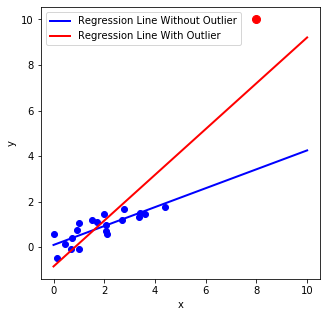

In [65]:
from sklearn.linear_model import LinearRegression
np.random.seed(1)
# Let's generate some data with outliers, train some linear regression model...
X = np.random.uniform(0, 5, size = 20)
X = np.sort(X)
X_with_outliers = np.append(X, 8)
X_with_outliers = np.sort(X_with_outliers)
y = 0.5 * X + np.random.normal(scale=0.5, size = 20)
y_with_outliers = np.append(y, 10)
lin_reg = LinearRegression()
lin_reg.fit(X.reshape(20,1),y)
pred_no_outliers = lin_reg.predict(np.linspace(0,10,10).reshape(10,1))
lin_reg.fit(X_with_outliers.reshape(21,1), y_with_outliers)
pred_with_outliers = lin_reg.predict(np.linspace(0,10,10).reshape(10,1))
# ...and plot the results
plt.figure(figsize=(5,5))
plt.plot(X, y, 'bo',markersize=6)
plt.plot(X_with_outliers[-1], y_with_outliers[-1], 'ro',markersize=8)
plt.plot(np.linspace(0,10,10), pred_no_outliers, "b-", label="Regression Line Without Outlier", linewidth=2)
plt.plot(np.linspace(0,10,10), pred_with_outliers, "r-", label="Regression Line With Outlier", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=10)
plt.show()

Thus, it is important to be able to properly detect and handle outliers before training the algorithms. In what follows we will consider two methods: 
 * Elliptic Covariance methods
 * Isolation Forest 

An overview of outlier detection techniques is given in [this link](https://scikit-learn.org/stable/modules/outlier_detection.html). 

### 6.1 Elliptic Covariance 

*Elliptic Covariance* is a unsupervised outlier detection method which assumes a multivariate Gaussian distribution for the data, imposing a 'hyper-ellipse' around the central data points; it then uses the (Malhanobis) distance from the data center to define a measure of 'outlyingness'. Here we can see an example on how to use it with scikit-learn. The hyperparameter `support_fraction` denotes the fraction of central data points used to estimate the covariance matrix; the hyperparameter `contamination` is used to indicate the fraction of outliers that the method must find. 

**Example on the toy dataset**: 

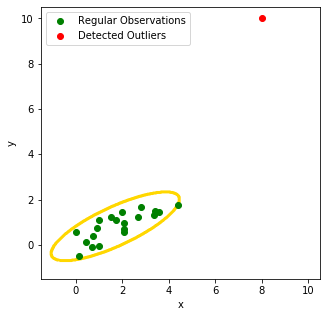

In [66]:
from sklearn.covariance import EllipticEnvelope
toy_data = pd.concat([pd.Series(X_with_outliers), pd.Series(y_with_outliers)], axis=1)
# Fit the Gaussians with 100% of the central data points, and detect (at most) 5% outliers
ell_cov = EllipticEnvelope(support_fraction=1., contamination=0.05, random_state=1)
# Outliers are denoted by -1 
outlier_predicted = ell_cov.fit(toy_data).predict(toy_data)
xx, yy = np.meshgrid(np.linspace(-1.5, 10.5, 500), 
                    np.linspace(-1.5, 10.5, 500))
zz = ell_cov.predict(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)
plt.figure(figsize=(5,5))
plt.contour(xx, yy, zz, levels=[0], linewidths=3, colors='gold')
plt.plot(toy_data.iloc[outlier_predicted==1,0], toy_data.iloc[outlier_predicted==1,1], 'go',markersize=6,
        label="Regular Observations")
plt.plot(toy_data.iloc[outlier_predicted==-1,0], toy_data.iloc[outlier_predicted==-1,1], 'ro',markersize=6, 
        label="Detected Outliers")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

*Note*: in case of multi-modal data, methods such as [`Gaussian mixture models`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) for outlier detection should be preferred. 

**Example on the *Heart* data** (Elliptic Covariance): because outlier removal should be performed *before* data scaling, we retrieve the dataset obtained after median imputation, and we predict outliers on such data. As Elliptic Covariance assumes a multivariate Gaussian distribution, we only use the continuous features.  

In [67]:
# Fit Elliptic Envelope
ell_cov = EllipticEnvelope(support_fraction=1., contamination=0.05, random_state=1)
train_ellcov_outliers = ell_cov.fit(X_train_cont_imp)
train_ellcov_outliers = ell_cov.predict(X_train_cont_imp)
test_ellcov_outliers = ell_cov.predict(X_test_cont_imp)
# Outliers are denoted by -1 
test_ellcov_outliers[:50]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1])

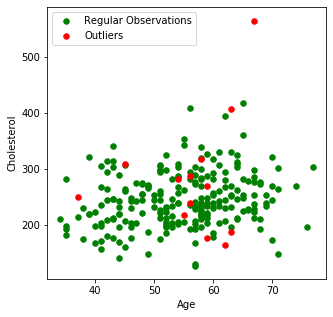

In [68]:
# Let's visualize the outliers with two selected variables (Age vs. Cholesterol)
plot_vars = X_train_cont_imp.iloc[:,[1,3]]
cols = np.array(['green', 'red'])
plt.figure(figsize=(5, 5))
plt.scatter(plot_vars.iloc[train_ellcov_outliers==1,0], 
            plot_vars.iloc[train_ellcov_outliers==1,1], 
           c=cols[0], s=30, label='Regular Observations')
plt.scatter(plot_vars.iloc[train_ellcov_outliers==-1,0], 
            plot_vars.iloc[train_ellcov_outliers==-1,1], 
           c=cols[1], s=30, label='Outliers')
plt.xlabel("Age")
plt.ylabel("Cholesterol")
plt.legend()
plt.show()
# Some outliers appear to be inside main data cloud; 
# can you motivate this result? 

### 6.2 Isolation Forest

**Isolation Forest** is an *ensemble method* (that is, it combines the results of several, repeatedly trained algorithms -- we will explore ensembles in one of the last lectures) -- that allows for outlier detection. 

The functioning of the algorithm will become clearer after the lectures on *Decision Trees* and *Random Forests*. For the moment, it is sufficient to know the rough idea behind the algorithm: Isolation Forest performs several splits at random locations in the interior of the features space for several bootstrap replications, until all possible training point are *isolated* from the others. Outliers tend to become isolated faster than the rest of the data points, and are given low scores, while other points (*inliers*) are given higher scores; after averaging such scores over all bootstrap replications, the algorithm labels as outliers all the examples with lowest average scores. Isolation Forest can automatically recognize the proportion of outliers, but it can also select a desired amount of outliers (with the `contamination` hyperparameter). Furthermore, as it does not assume any distribution for the data, it can work with both numeric and (encoded) categorical attributes. Isolation Forest works well especially with high-dimensional datasets.    

**Example on the toy dataset**:

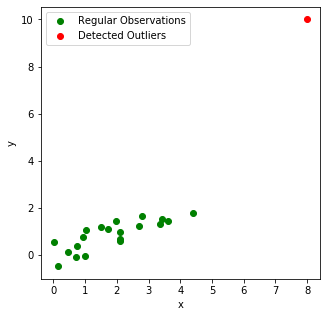

In [69]:
from sklearn.ensemble import IsolationForest
# Fit isolation forest
iso_for = IsolationForest(n_estimators=50, contamination=0.05, random_state=1)
# Outliers are denoted by -1 
outlier_predicted = iso_for.fit(toy_data).predict(toy_data)

plt.figure(figsize=(5,5))
plt.plot(toy_data.iloc[outlier_predicted==1,0], 
         toy_data.iloc[outlier_predicted==1,1], 'go',markersize=6,
        label="Regular Observations")
plt.plot(toy_data.iloc[outlier_predicted==-1,0], 
         toy_data.iloc[outlier_predicted==-1,1], 'ro',markersize=6, 
        label="Detected Outliers")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

**Example on the *Heart* data** (Isolation Forest): as seen for the Elliptic Covariance method, we perform outlier removal before the data scaling; in this case, we take the continuous and categorical datasets obtained after imputation and encoding, and apply Isolation Forest. Before that, we are going to merge these datasets as done above in the section *Merging the Datasets* (this is because Isolation Forest, unlike the Elliptic Covariance method, can be estimated also with encoded and dummy categorical variables!): 

In [70]:
X_train_cont_imp.index = X_train.index
X_train_cat_oh_enc.index = X_train.index 
X_test_cont_imp.index = X_test.index
X_test_cat_oh_enc.index = X_test.index 

X_train_iso_forest = pd.concat([X_train_cont_imp, X_train_cat_oh_enc, X_train_bin], 
                               axis=1)
X_test_iso_forest = pd.concat([X_test_cont_imp, X_test_cat_oh_enc, X_test_bin], 
                              axis=1 )

X_train_iso_forest.columns = new_var_names
X_test_iso_forest.columns = new_var_names

In [71]:
# Fit isolation forest 
iso_for = IsolationForest(contamination=0.05, random_state=1)
# Notice that the method is now implemented including categorical features 
# (we could also have run it exclusively on numerical ones)
train_isofor_outliers = iso_for.fit(X_train_iso_forest)
train_isofor_outliers = iso_for.predict(X_train_iso_forest)
test_isofor_outliers = iso_for.predict(X_test_iso_forest)
# Outliers are denoted by -1 
test_isofor_outliers[:15]

array([ 1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [72]:
# Proportion of detected outliers in the training/test data
[(train_isofor_outliers == -1).mean(),
(test_isofor_outliers == -1).mean()]

[0.05371900826446281, 0.04918032786885246]

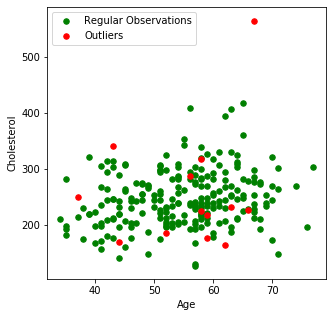

In [73]:
# Let's visualize the outliers with two selected variables (Age vs. Cholesterol)
plot_vars = X_train_iso_forest[['Age','Chol']]
cols = np.array(['green', 'red'])
plt.figure(figsize=(5, 5))
plt.scatter(plot_vars.iloc[train_isofor_outliers==1,0], 
            plot_vars.iloc[train_isofor_outliers==1,1], 
           c=cols[0], s=30, label='Regular Observations')
plt.scatter(plot_vars.iloc[train_isofor_outliers==-1,0], 
            plot_vars.iloc[train_isofor_outliers==-1,1], 
           c=cols[1], s=30, label='Outliers')
plt.xlabel("Age")
plt.ylabel("Cholesterol")
plt.legend()
plt.show()

**Note**: If you want to remove outliers with the values predicted, for instance by Isolation Forest, you can filter them out as follows:

```python
X_train = X_train[train_isofor_outliers==1]
y_train = y_train[train_isofor_outliers==1]
X_test = X_test[test_isofor_outliers==1]
y_test = y_test[test_isofor_outliers==1]
```
- - - 


Clustering techniques, such as [`DBScan`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html) and [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) can also be used for outlier detection. These methods will be explored later in the course. 

*** 

## 7. Dimensionality Reduction

In many situations, raw data consists of several hundreds (of thousands!) of features. Being able to reduce the number of features before running the algorithms for analysis is very important: succesfully doing so can decrease the computational time of the algorithms, improve model interpretability, and decrease **noise** (a concept we are going to explore in one of the next lectures). "Succesfully" here means that we must be able to remove from the dataset only those features that are not informative for the prediction of the class/outcome variable. Failing to do so, on the other hand, can be detrimental for the analysis and the interpretation of the final results. Therefore, dimensionality reduction is a very delicate step that must be executed carefully.

We are going to explore three ways of reducing the number of features: 
 * removal of uninformative variables 
 * feature selection
 * PCA
 
 In the `scikit-learn` documentation, you can find more information about [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) and [dimensionality reduction](https://scikit-learn.org/stable/modules/unsupervised_reduction.html). 

### 7.1 Uninformative Variables
We can detect two types of uninformative variables: 
 * (non-continuous) variables for which each examples has its own value (e.g., ID labels)
 * variables with zero-variance or near-zero variance
 
The first group of variables can be detected with some knowledge of the data at hand. For instance, in the *Heart* data, the first variable (ID) can be considered uninformative for the prediction of the class; knowing the patient ID does not give us any information about his probability of having the heart disease. Furthermore, retaining these type of variables in the dataset will produce *overfitting* models in the training stage: the algorithm will learn to map each ID to the presence/absence of disease, without being able to generalize to new cases (that have new ID). (Don't worry if you don't understand yet the meaning of some terms, such as overfitting; we are going to see all of them in the coming lectures). We can therefore safely remove the ID variable from our dataset:

In [74]:
X_train_processed.drop(["ID"], axis=1, inplace=True)
X_test_processed.drop(["ID"], axis=1, inplace=True)
# X_train_processed.head()

Variables with (near) zero-variance, on the other hand, are attributes that are almost constant, or completely constant across examples. As such, they cannot be informative for predictions, and can be safely removed. In `scikit-learn`, the function `VarianceThreshold` can be used to detect such features. 

In [75]:
from sklearn.feature_selection import VarianceThreshold
# Let's detect (if present) all variables with variance below 0.01: 
zv_features = VarianceThreshold(threshold=0.01)
zv_features.fit(X_train_processed)
{X_train_processed.columns[x]:zv_features.variances_[x].round(3) 
 for x in range(X_train_processed.shape[1])}

{'Age': 1.0,
 'RestBP': 1.0,
 'Chol': 1.0,
 'RestECG': 1.0,
 'MaxHR': 1.0,
 'Oldpeak': 1.0,
 'Slope': 1.0,
 'Ca': 1.0,
 'CholBySex': 1.0,
 'ChestPain_asymptomatic': 0.249,
 'ChestPain_nonanginal': 0.204,
 'ChestPain_nontypical': 0.138,
 'ChestPain_typical': 0.076,
 'Thal_fixed': 0.051,
 'Thal_normal': 0.247,
 'Thal_reversable': 0.238,
 'Sex': 0.224,
 'Fbs': 0.141,
 'ExAng': 0.217}

All variances are above the specified threshold; notice that, if we were to specify a threshold variance of 0.06 instead of 0.01, `VarianceThreshold` would remove the "Thai_fixed" attribute by applying the `transform` operator. 

### 7.2 Feature Selection 
Not all features are necessarily good predictors of the class/output. `scikit-learn` provides a module, `feature_selection`, that can be used to perform feature selection. In general, feature selection works by assigning a score to each feature, according to some criterion; features with lowest scores are the candidate ones for removal. <br> 
Here we are going to explore two methods provided by `feature_selection`: 
 * `SelectKBest()`
 * `SelectFromModel()`

Many other methodologies are possible; students are invited to check the `scikit-learn` [documentation](https://scikit-learn.org/stable/modules/feature_selection.html) to find them out. 

### 7.2.1 SelectKBest()
`SelectKBest` is a univariate method; that is, it sequentially performs univariate tests based on some measure provided by the user. The function will then detect the $k$ best features according to such scores; $k$ is a hyperparameter too. Among the possible measures, we can find: 
 * `f_classif` (F-test score for the model fit of an ANOVA in classification tasks)
 * `chi2` (chi-square score for classification)
 * `f_regression` (F_test score for the model fit of a regression model in a regression task)
 * measures based on *mutual information* (a measure of dependency)
 
 In this example, we run `SelectKBest` setting $k=15$: 

In [76]:
# Example with f_classif and 15 best features: 
from sklearn.feature_selection import SelectKBest, f_classif
skb = SelectKBest(score_func= f_classif, k=15 )
skb.fit(X_train_processed, y_train)

SelectKBest(k=15, score_func=<function f_classif at 0x7f30bac33670>)

In [77]:
skb.scores_.round(decimals=1)

array([  8.8,   5.4,   1.2,   9.3,  38.5,  50.8,  33.6,  60.4,  27.6,
        96.1,  24.8,  19.7,   2.2,   3. , 103.9,  83.7,  22.2,   0. ,
        42. ])

At this point, both the training and the test data can be reduced with the `transform` method, which will retain only the 15 features with the highest score. 

### 7.2.3 SelectFromModel()
The principle of SelectFromModel is simple: you feed the function with a scikit-learn estimator, used as base model (for instance, linear regression/logistic regression), and the function will return the importance weights of each feature. Unlike SelectKBest, this method is *multivariate*: it accounts for the dependencies of all features with the output simultaneously. The feature importance scores returned by the base estimator (for example, the coefficients of a regression model) are compared against a threshold value (which can be user-defined) to select the features to retain and the ones to remove. 

In this example, we are going to use the Logistic Regression model as a classifier for such method.

In [78]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
sel_log_reg = SelectFromModel(estimator=LogisticRegression())
sel_log_reg.fit(X_train_processed, y_train)
sel_log_reg.estimator_.coef_

array([[-0.10827542,  0.4134435 , -0.0329594 ,  0.44362976, -0.35097014,
         0.48468005,  0.32770677,  1.03180437,  0.50325048,  1.26389338,
        -0.58412144,  0.03921936, -0.71885711, -0.192066  , -0.63908394,
         0.83128413,  0.13520807, -0.52566583,  0.53745588]])

In [79]:
# We have used the default threshold, which is the means of the coefficients
sel_log_reg.threshold_

0.48229342180938856

In [80]:
# Which features would be retained if we applied the transform() method?
sel_log_reg.get_support()

array([False, False, False, False, False,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True, False,  True,
        True])

Another typical choice for SelectFromModel() is linear/logistic regression with [lasso](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_boston.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-boston-py) penalty; as we will see in future lectures, this penalty have the benefit to shrink some of the coefficients to 0. <br>
Other common models for feature selection are "ensembles"; they can take into account non-linearities and potential interactions among features. After the training stage, they provide a measure of 'feature importance'. Here we will show an example with Random Forest: 

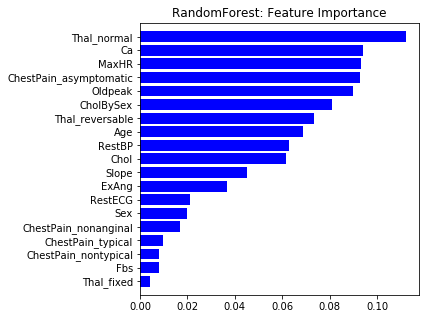

In [81]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train_processed, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(5,5))
plt.barh(range(X_train_processed.shape[1]), importances[indices], color='b', align='center')
plt.yticks(range(X_train_processed.shape[1]), [X_train_processed.columns[v] for v in indices])
plt.ylim([-1, X_train_processed.shape[1]])
plt.title("RandomForest: Feature Importance")
plt.show()

### 7.3 PCA 

In PCA, the goal is different from identifying a number of observed features that best explain the class/output. Instead, we seek to find a transformation (*linear combination*) of the features; these transformed features, called *components*, lie in the main directions (that is, the *eigenvectors*) of the features covariance matrix, and are orthogonal (=**uncorrelated**) of each other. The goal is to reduce the number of features while retaining as much of the original information (=variability) as possible. PCA can also be used to visualize high-dimensional data. <br>
PCA for dimensionality reduction works as follows. First, calculate the component scores with: 

$$\mathbf{Z} = \mathbf{XW},$$ 

that is, 
$$\mathbf{z}_{id} = w_{1d}x_{i1}+w_{2d}x_{i2}+...+w_{pd}x_{ip}$$

where $p$ is the number of features, $i$ indexes the observations, $d$ indexes the components, $\mathbf{Z}$ is the component scores matrix, $\mathbf{X}$ is the original feature matrix, and $\mathbf{W}$ is the matrix of the eigenvectors, which comes from the eigendecomposition

$$ \mathbf{\Sigma} = \mathbf{W\Lambda W} $$ 

($\mathbf{\Sigma}$ is the covariance matrix of $\mathbf{X}$ and $\mathbf{\Lambda}$ is the diagonal matrix of eigenvalues, ordered from the largest to the smallest). Second, consider how much of the observed variance each component can explain. This can be done by considering the eigenvalues. Third, select those $D$ components that can explain a pre-established fraction of the total variance (e.g., 90%). Because the components are linear combinations of the original attributes, they can be interpreted by observing how much each attribute *loads* in the component; this is given by the values of the weights, $\mathbf{W}$. Importantly, although PCA will run also with one-hot encoded and ordinal-encoded features, it is a method originally conceived for continuous data. Therefore, in the next example we will run it on the continuous part of the Heart dataset. 

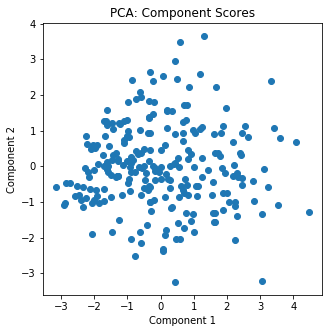

In [82]:
from sklearn.decomposition import PCA
pca_model = PCA(random_state=1)
# Drop "ID" from columns
X_pca = X_train_cont_standardized.drop(0, axis=1)
pca_model.fit(X_pca)
# Plot the first two principal components 
plt.figure(figsize=(5,5))
# Note: Components are calculated with XW
plt.scatter(X_pca.dot(pca_model.components_[0]), 
           X_pca.dot(pca_model.components_[1]))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA: Component Scores")
plt.show()

As we can notice, the components are uncorrelated with each other. We can also visualize how the first two components separate the classes (note that, being an unsupervised learning technique, PCA does not use information about the class when it is estimated):  

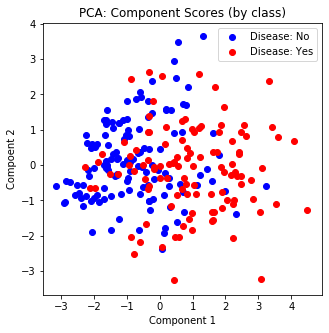

In [83]:
# Plot the first two principal components , colored by class
plt.figure(figsize=(5,5))
plt.scatter(X_pca[y_train==0].dot(pca_model.components_[0]), 
            X_pca[y_train==0].dot(pca_model.components_[1]),
            c="blue", label="Disease: No")
plt.scatter(X_pca[y_train==1].dot(pca_model.components_[0]), 
            X_pca[y_train==1].dot(pca_model.components_[1]),
            c="red", label="Disease: Yes")
plt.xlabel("Component 1")
plt.ylabel("Compoent 2")
plt.title("PCA: Component Scores (by class)")
plt.legend()
plt.show()

It seems that the first two components cannot completely separate the classes in their own space (at least graphically). Let's now explore the loadings of the first component:

In [84]:
vars_loadings_first_component = zip(X_train_cont.columns[1:], 
                                        pca_model.components_[0])
dict(vars_loadings_first_component)

{'Age': 0.41026292241554047,
 'RestBP': 0.2448484171345302,
 'Chol': 0.1474818120612085,
 'RestECG': 0.21610413861308003,
 'MaxHR': -0.4093864440049785,
 'Oldpeak': 0.4594885551565214,
 'Slope': 0.43345033512712183,
 'Ca': 0.35488182612236663,
 'CholBySex': 0.10360698390836333}

This component seems to capture linear combinations of features such as *Age*, *RestBP*, *RestECG*, *MaxHR*, *Slope*, and *Ca*, which are (negatively or positively) strongly correlated with the component. <br>
We can also look at the cumulative explained variability of the components:

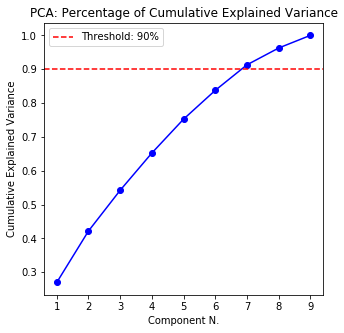

In [85]:
plt.figure(figsize=(5,5))
plt.plot(range(1,10),np.cumsum(pca_model.explained_variance_ratio_), "bo")
plt.plot(range(1,10),np.cumsum(pca_model.explained_variance_ratio_), "b-")
plt.axhline(y=0.9, color='r', linestyle='--', label="Threshold: 90%")
plt.title("PCA: Percentage of Cumulative Explained Variance")
plt.xticks(range(1,10),range(1,10))
plt.xlabel("Component N.")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.show()

At least 90% of the variability in the original continuous data (as marked by the red line), is included in the first 7 components:

In [86]:
np.cumsum(pca_model.explained_variance_ratio_)[:10]

array([0.26963316, 0.42161137, 0.5420348 , 0.65218535, 0.75236055,
       0.83750995, 0.91292612, 0.96259965, 1.        ])

The transformation can be achieved (but not done here) as follows: 

```python
# n_components can be given the ratio of variance we want to preserve:
pca_mod_2 = PCA(n_components=0.9, random_state=1)
X_train_processed = pd.DataFrame(pca_mod_2.fit_transform(X_pca))
X_test_processed = pd.DataFrame(pca_mod_2.transform(X_pca))
```

In this way, we would reduce the number of continuous features from 9 to 7. The disadvantage is that the features are now linear combinations of the original ones, and might be hard to interpret.

*Note*: When re-merging the new PCA component with the rest of the dataset, remember to use the `index` of the original dataset, as done above (section: `Merging the Datasets`).

## 8. Imbalanced Data 

**Note**: `scikit-learn` does not have methods to deal with imbalanced datasets. To work with the methods described in this section, you need to install the `imbalanced-learn` [library](https://github.com/scikit-learn-contrib/imbalanced-learn). You can install it by running:
```
pip install -U imbalanced-learn
``` 
on your terminal.

In order to present the next methods, we are going to modify the dataset by removing observations from one of the two classes. 

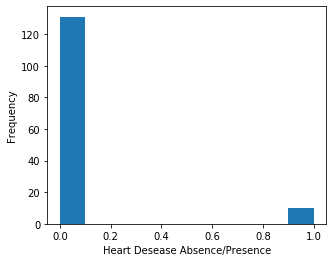

In [87]:
tmp_train_data = pd.concat([X_train_processed, y_train],axis=1).rename(columns={0:"y"})
tmp_test_data = pd.concat([X_test_processed, y_test],axis=1).rename(columns={0:"y"})
# We are now going to 'imbalance' the dataset
disease_train_examples = tmp_train_data.loc[tmp_train_data["y"]==1]
disease_train_examples = disease_train_examples[0:10]
disease_test_examples = tmp_test_data.loc[tmp_test_data["y"]==1]
disease_test_examples = disease_test_examples[0:2]
imb_train_data = pd.concat([tmp_train_data.loc[tmp_train_data["y"]==0], disease_train_examples])
imb_test_data = pd.concat([tmp_test_data.loc[tmp_test_data["y"]==0], disease_test_examples])
plt.figure(figsize=(5,4))
plt.xlabel("Heart Desease Absence/Presence")
plt.ylabel("Frequency")
imb_train_data["y"].hist(grid=False)
plt.show()

In [88]:
imb_train_data["y"].value_counts()

0    131
1     10
Name: y, dtype: int64

What we have just created is an *imbalanced* dataset; that is, a dataset where we have much more observations for one class rather than for the other. While here we have artificially made the dataset imbalanced, in the real world having to deal with imbalanced situations is very common. <br>
Imbalanced datasets are tricky for machine learning algorithms. Consider the following example: we simple create a learner that predicts the negative class (class denoted with 0) for all observations. Although this algorithm is not very informative for us, it reaches a relatively high accuracy on the test data:

In [89]:
# Accuracy using a classifier that predicts all instances as '0'
(imb_test_data["y"] == 0).sum() / imb_test_data.shape[0]

0.9428571428571428

In the next lecture, we will deal with measures other than accuracy for cases of imbalance data. However, there are also preprocessing techniques that can help Data Mining classifiers to obtain good performance, while producing informative results. The techniques we will see in this section are: 
* undersampling
* oversampling
* SMOTE

Importantly, all these methodologies must be applied **only to the training set**, as we need balanced datasets only for the training stage. The test set can be left untouched. 
A detailed overview of these (and other) techniques can be found in the `imbalanced-learn` [package documentation](https://imbalanced-learn.readthedocs.io/en/stable/user_guide.html).

### 8.1 Undersampling
With undersampling, we randomly select units from the majority class and remove them from the dataset, in such a way to obtain a more balanced dataset. This method has the advantage of reducing the running time of the algorithms and the space required to store the dataset. However, it has the obvious disadvantage to remove useful information. 

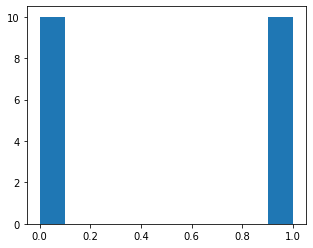

In [90]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = undersampler.fit_resample(imb_train_data.drop(["y"],axis=1), imb_train_data["y"])
plt.figure(figsize=(5,4))
y_resampled.hist(grid=False)
plt.show()

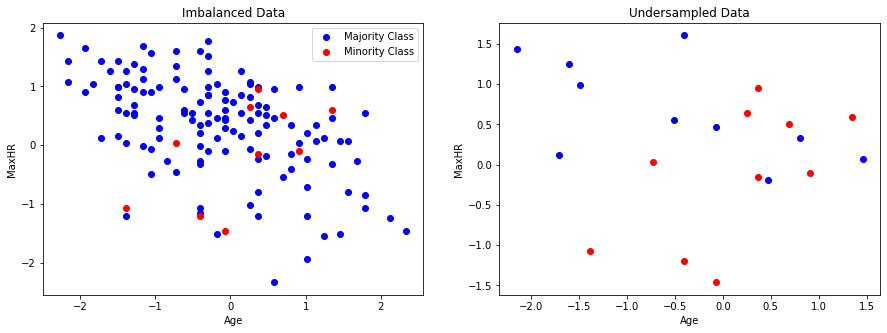

In [91]:
vars =["Age", "MaxHR"]
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(imb_train_data.loc[imb_train_data["y"]==0,vars[0]], 
        imb_train_data.loc[imb_train_data["y"]==0,vars[1]], "bo", label="Majority Class")
ax.plot(imb_train_data.loc[imb_train_data["y"]==1,vars[0]], 
        imb_train_data.loc[imb_train_data["y"]==1,vars[1]], "ro", label = "Minority Class")
ax2.plot(X_resampled.loc[y_resampled==0,vars[0]], 
        X_resampled.loc[y_resampled==0,vars[1]], "bo", label="Majority Class")
ax2.plot(X_resampled.loc[y_resampled==1,vars[0]], 
        X_resampled.loc[y_resampled==1,vars[1]], "ro", label = "Minority Class")
ax.set_title("Imbalanced Data")
ax2.set_title("Undersampled Data")
ax.set_xlabel("Age")
ax.set_ylabel("MaxHR")
ax2.set_xlabel("Age")
ax2.set_ylabel("MaxHR")
ax.legend()
plt.show()

### 8.2 Oversampling
*Oversampling* does the opposite of undersampling: instead of randomly removing examples from the majority class, it randomly samples (with replacement) examples from the minority class. Unlike oversampling, in this case there is no loss information. This method, however, has the disadvantage to make the machine learning models prone to *overfitting*, as algorithms will learn from replicated data points. 

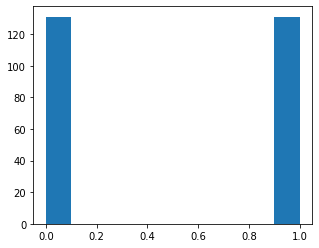

In [92]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=1)
X_resampled, y_resampled = oversampler.fit_resample(imb_train_data.drop(["y"],axis=1), imb_train_data["y"])
plt.figure(figsize=(5,4))
y_resampled.hist(grid=False)
plt.show()

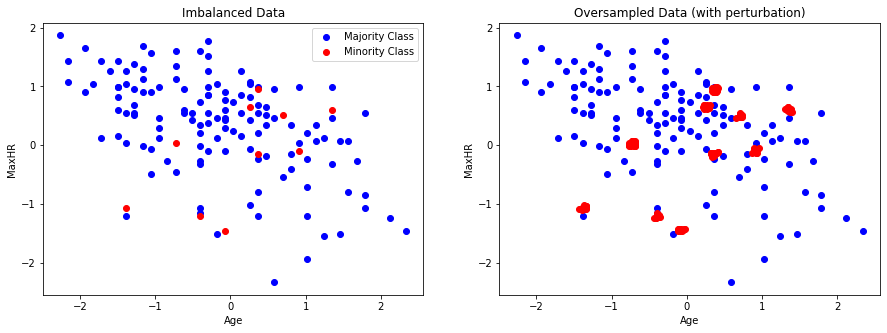

In [93]:
vars =["Age", "MaxHR"]
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(imb_train_data.loc[imb_train_data["y"]==0,vars[0]], 
        imb_train_data.loc[imb_train_data["y"]==0,vars[1]], "bo", label="Majority Class")
ax.plot(imb_train_data.loc[imb_train_data["y"]==1,vars[0]], 
        imb_train_data.loc[imb_train_data["y"]==1,vars[1]], "ro", label = "Minority Class")
ax2.plot(X_resampled.loc[y_resampled==0,vars[0]], 
        X_resampled.loc[y_resampled==0,vars[1]],
         "bo", label="Majority Class")
ax2.plot(X_resampled.loc[y_resampled==1,vars[0]] + np.random.uniform(-5e-2, 5e-2, (y_resampled == 1).sum()), 
        X_resampled.loc[y_resampled==1,vars[1]] + np.random.uniform(-5e-2, 5e-2, (y_resampled == 0).sum()),
         "ro", label = "Minority Class")
ax.set_title("Imbalanced Data")
ax2.set_title("Oversampled Data (with perturbation)")
ax.set_xlabel("Age")
ax.set_ylabel("MaxHR")
ax2.set_xlabel("Age")
ax2.set_ylabel("MaxHR")
ax.legend()
plt.show()

### 8.3 SMOTE
**SMOTE** (Synthetic Minority Over-sampling Technique) is a way to artificially create new examples from the minority class (it can then be considered a special way to do oversampling). The rationale behing this method is very simple: (1) pick a random point from the minority class; (2) consider its $k$ (a hyperparameter) closest neighbors (according to some distance function); (3) randomly generate a new observation which randomly lies between the data point and one of its neighbors. <br>
Because it is creating new observations, SMOTE has the advantage of mitigating the effect of overfitting. However, it is not always effective in high dimensions. 

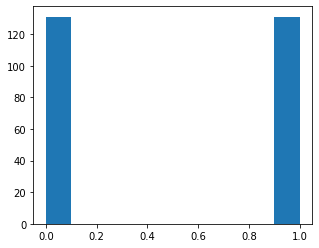

In [94]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors = 5, random_state=1)
X_resampled, y_resampled = smote.fit_resample(imb_train_data.drop(["y"],axis=1), imb_train_data["y"])
plt.figure(figsize=(5,4))
y_resampled.hist(grid=False)
plt.show()

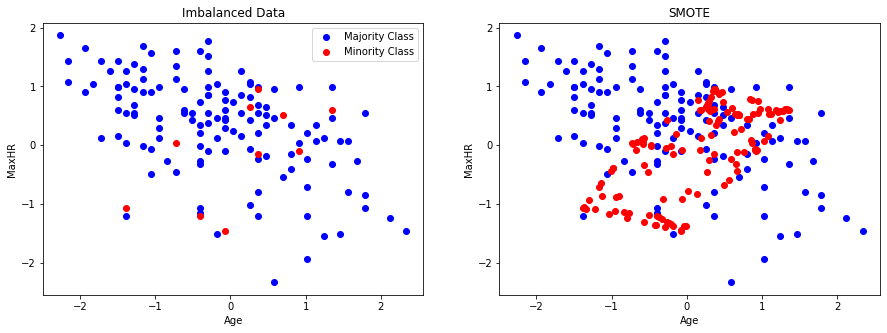

In [95]:
vars =["Age", "MaxHR"]
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(imb_train_data.loc[imb_train_data["y"]==0,vars[0]], 
        imb_train_data.loc[imb_train_data["y"]==0,vars[1]], "bo", label="Majority Class")
ax.plot(imb_train_data.loc[imb_train_data["y"]==1,vars[0]], 
        imb_train_data.loc[imb_train_data["y"]==1,vars[1]], "ro", label = "Minority Class")
ax2.plot(X_resampled.loc[y_resampled==0,vars[0]], 
        X_resampled.loc[y_resampled==0,vars[1]], "bo", label="Majority Class")
ax2.plot(X_resampled.loc[y_resampled==1,vars[0]], 
        X_resampled.loc[y_resampled==1,vars[1]], "ro", label = "Minority Class")
ax.set_title("Imbalanced Data")
ax2.set_title("SMOTE")
ax.set_xlabel("Age")
ax.set_ylabel("MaxHR")
ax2.set_xlabel("Age")
ax2.set_ylabel("MaxHR")
ax.legend()
plt.show()

**Note**: both SMOTE and oversampling can lead to non-realistic results if not handled carefully. For example, they can't be run before doing *cross-validation* (a model validation method that we will explore in the coming lectures). Instead, they should be perfomed *within each cross-validation round*, otherwise we incur into overfitting, and will then obtain too optimistic results. 

## 9. Exporting preprocessed data

Once our preprocessed data has been created, it is possible to save it (if memory in disk allows it) and recover it for subsequent analysis with `to_csv`: 

In [96]:
pd.concat([X_train_processed, y_train],axis=1).rename(columns={0:"y"}).to_csv("data/heart_data/heart_train_processed.csv", index=False)
pd.concat([X_test_processed, y_test],axis=1).rename(columns={0:"y"}).to_csv("data/heart_data/heart_test_processed.csv", index=False)

## 10. Final Remarks on Data Preprocessing
In this lecture, we have gone through some of the most common preprocessing methodologies typical of Data Mining. The order in which each of the presented steps is performed is important, as results may change significantly when their order is modified. However, there is no general rule that says which method must be applied before/after other ones (although some logical reasoning can be used: for instance, outlier removal should be performed before scaling). 

Ultimately, what is important is to return a clean dataset, with features that share the same scale. Students are invited to try the effect of changing the order of the presented pre-processing techniques, in order to appreciate how these modify the resulting dataset. It is important to have a solid knowledge of the dataset at hand in order to apply with certainty some specific methodology; for instance, knowing that there are data *missing completely at random* can lead us to drop units with missing cases quite safely (if the sample size is large enough). Otherwise, it is important to test how different approaches (for example, dropping cases vs. imputation) can affect the final results. Furthermore, changing the hyperparameters of each preprocessing method (such as, for example, the score function of a feature selector) is also likely to have an effect on the accuracy of the machine learning algorithm applied in later steps. Therefore, such hyperparameters can be treated as any other hyperparameter of the Data Mining models that we are going to explore in this course.